# Dry Run with Sample File - Local

## Environment and Custom Functions

In [20]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
import fastparquet as fp

In [21]:
def print_shape(df):
    print(f"Rows: {df.shape[0]:,} \nColumns: {df.shape[1]:,}")

In [22]:
def keep_latest(df, dedupe_by_cols, sort_by_cols):
    """Keep last record for each unique combination of dupe_cols, ordering by sort_cols"""
    df = df.sort_values(sort_by_cols).drop_duplicates(dedupe_by_cols, keep="last")
    return df

In [23]:
# calculate percent missing for each field in df
def percent_missing(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    # Print some summary information
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )
    # Return the dataframe with missing information
    return mis_val_table_ren_columns


In [24]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def test_results(y_test, y_pred):
    print("R2: ", round(r2_score(y_test, y_pred),3))
    print("MAE: ", round(mean_absolute_error(y_test, y_pred),2))
    print("MAPE: ", round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,1),"%")
    print("RMSE: ", round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
    print("Percent Underpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) >= 0]) / len(y_test) * 100,1),"%")
    print("Mean of Underpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) > 0]),2))
    print("Percent Overpayed: ", round(len((y_test - y_pred)[(y_test - y_pred) < 0]) / len(y_test) * 100,1),"%")
    print("Mean of Overpayment: ", round(np.mean((y_test - y_pred)[(y_test - y_pred) < 0]),2))
    print("Mean Error: ", round(np.mean(y_test - y_pred),2)) 
    

## Load Data

In [25]:
standard_features_file = "/Users/shea/Downloads/sync_exclude/large_sample-standard_features.parquet"
df = fp.ParquetFile(standard_features_file).to_pandas()
df["engine_size"] = df["engine_size"].astype("float")
print_shape(df)


Rows: 1,858,778 
Columns: 31


In [26]:
hvf_options_file = "/Users/shea/Downloads/sync_exclude/hvf_options.parquet"
hvf_options = fp.ParquetFile(hvf_options_file).to_pandas()
print_shape(hvf_options)

Rows: 1,585,169 
Columns: 82


In [27]:
# join df and hvf_options on index
df = df.join(hvf_options, how="left")

hvf_column_eg = "Turbo Boost"

# perecent of null hvf column that's null grouped by year
df.groupby("year")[hvf_column_eg].agg(lambda x: sum(x.isnull()) / len(x))

year
1981.0    1.000000
1982.0    1.000000
1983.0    1.000000
1984.0    1.000000
1985.0    1.000000
1986.0    1.000000
1987.0    1.000000
1988.0    1.000000
1989.0    1.000000
1990.0    1.000000
1991.0    1.000000
1992.0    1.000000
1993.0    1.000000
1994.0    1.000000
1995.0    1.000000
1996.0    1.000000
1997.0    0.556391
1998.0    0.458824
1999.0    0.436118
2000.0    0.378219
2001.0    0.413246
2002.0    0.398246
2003.0    0.377527
2004.0    0.369918
2005.0    0.372541
2006.0    0.367521
2007.0    0.344518
2008.0    0.315862
2009.0    0.315181
2010.0    0.268762
2011.0    0.246460
2012.0    0.230515
2013.0    0.209896
2014.0    0.214874
2015.0    0.245546
2016.0    0.182772
2017.0    0.134757
2018.0    0.050453
2019.0    0.018831
2020.0    0.019641
2021.0    0.015646
2022.0    0.021505
2023.0    0.018803
Name: Turbo Boost, dtype: float64

## Target Variable

In [28]:
# drop listing price var
# not using this because it's not available at time of listing
df.drop(columns=["price"], inplace=True)

In [29]:
# drop missing/0 price values
print_shape(df)
df = df[df["mvr_price"].notna()]
df = df[df["mvr_price"] > 1]
print_shape(df)

Rows: 1,858,778 
Columns: 112
Rows: 1,417,304 
Columns: 112


In [30]:
df["mvr_price"].describe()

count    1.417304e+06
mean     2.629080e+04
std      9.093204e+04
min      1.100000e+00
25%      1.552198e+04
50%      2.317900e+04
75%      3.323800e+04
max      1.000000e+08
Name: mvr_price, dtype: float64

In [31]:
# calculate high and low prices
top = df["mvr_price"].quantile(0.995)
print(top)
bottom = df["mvr_price"].quantile(0.005)
print(bottom)

94900.0
850.0


We're not sellin' Ferraris and Lamborghinis here. We're sellin' everyday used cars.

In [32]:
# keep mvr_price between top and bottom
print_shape(df)
df = df[df["mvr_price"] < top]
df = df[df["mvr_price"] > bottom]
print_shape(df)

Rows: 1,417,304 
Columns: 112
Rows: 1,403,090 
Columns: 112


<AxesSubplot:>

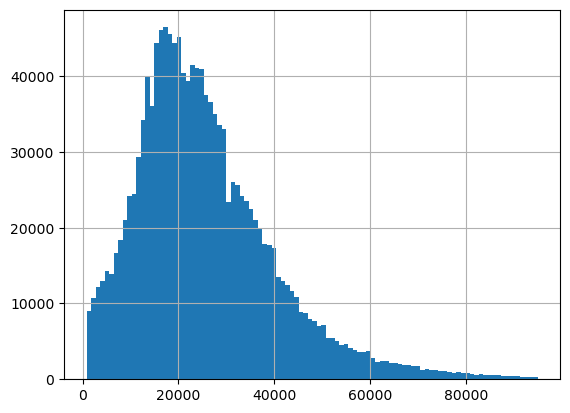

In [33]:
# plot distribution of mvr_price
df["mvr_price"].hist(bins=100)

/Users/shea/opt/miniconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:912: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/shea/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/shea/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/shea/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/shea/opt/miniconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


<AxesSubplot:>

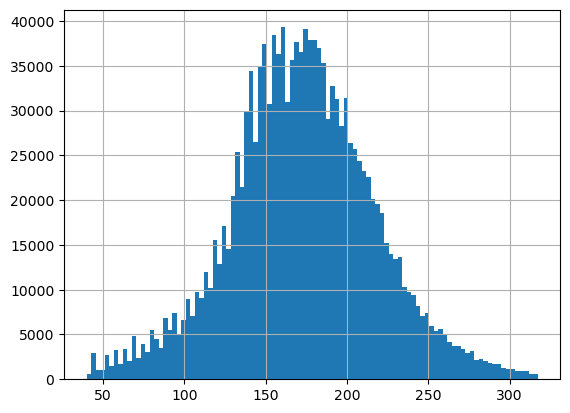

In [34]:
# box-cox transform mvr_price
from scipy import stats
df["mvr_price_bc"], bc_lambda = stats.boxcox(df["mvr_price"])
df["mvr_price_bc"].hist(bins=100)

In [35]:
df.drop(columns=["mvr_price_bc"], inplace=True)

## Feature Engineering

### Temporal

#### Vehicle Age

In [36]:
df["age"] = (df["mvr_purchase_date"].dt.year - df["year"] + 1)

<AxesSubplot:>

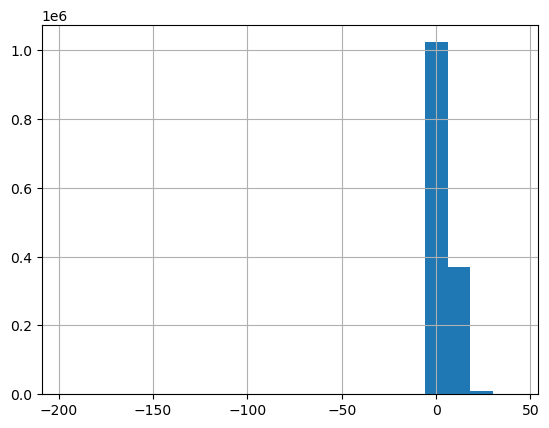

In [37]:
df["age"].hist(bins=20)

#### Month of Year

In [38]:
# purchase month
df["mvr_purchase_month"] = df["mvr_purchase_date"].dt.month.astype("category")

<AxesSubplot:>

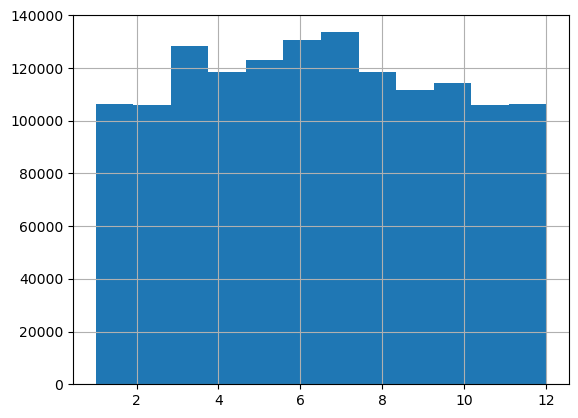

In [39]:
df["mvr_purchase_month"].hist(bins=12)

#### Business Cycle, etc.

### Numeric

#### Miles

In [40]:
df["miles"].quantile(0.995)

219902.0499999998

In [41]:
print_shape(df)
df = df[df["miles"] < 200000]
print_shape(df)

Rows: 1,403,090 
Columns: 114
Rows: 1,368,068 
Columns: 114


<AxesSubplot:>

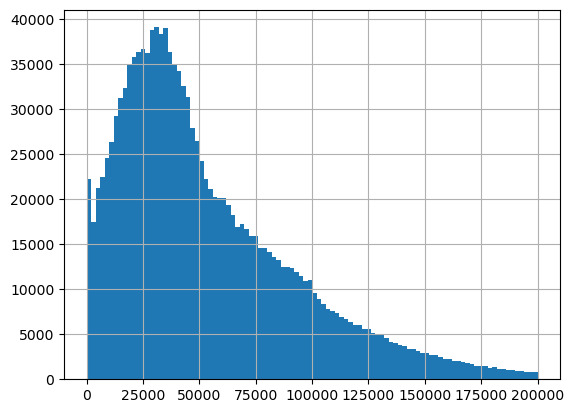

In [42]:
df["miles"].hist(bins=100)

#### Miles / Year

Capture the difference between a car that's driven a lot in a short period of time and a car that's driven a little in a long period of time, etc.

In [43]:
df["annual_mileage"] = df["miles"] / (df["age"] + 1)

In [44]:
df["annual_mileage"].describe()

count    1.366239e+06
mean              inf
std               NaN
min     -5.803600e+04
25%      5.178437e+03
50%      7.917778e+03
75%      1.111750e+04
max               inf
Name: annual_mileage, dtype: float64

#### Listing / Sale Date Difference

In [45]:
# difference between the last listing and the sale date recorded on the state registration
df["list_sale_diff"] = (df['mvr_purchase_date'] - df['status_date']).astype('timedelta64[D]')
print_shape(df)
# drop na's
df.dropna(subset=["list_sale_diff"], inplace=True)
print_shape(df)
# keep records with difference less than 90 days
df = df[abs(df["list_sale_diff"]) < 90]
print_shape(df)


Rows: 1,368,068 
Columns: 116
Rows: 1,368,065 
Columns: 116
Rows: 950,981 
Columns: 116


#### Fuel Economy

In [46]:
# epa weights city/highway 55/45
df["mpg"] = df["city_mpg"] * 0.55 + df["highway_mpg"] * 0.45
df.drop(columns=["city_mpg", "highway_mpg"], inplace=True)

In [47]:
# drop na's
print_shape(df)
df.dropna(subset=["mpg"], inplace=True)
print_shape(df)

Rows: 950,981 
Columns: 115
Rows: 898,218 
Columns: 115


#### Certified

In [48]:
df["is_certified"].fillna(0, inplace=True)

#### Photos

In [49]:
# rename photo_links_count to photo_count
df.rename(columns={"photo_links_count": "photo_count"}, inplace=True)

In [50]:
# cap at 100
df.loc[df["photo_count"] > 100, "photo_count"] = 100

In [51]:
df.drop(columns=["photo_main"], inplace=True)

### Categorical

#### Make

In [52]:
df["make"].value_counts()

Ford             125305
Chevrolet        121397
Toyota            85894
Nissan            67702
Honda             60746
Jeep              51126
GMC               38698
Kia               32489
Hyundai           31690
Dodge             30537
RAM               25649
BMW               24377
Volkswagen        19712
Lexus             19701
Mercedes-Benz     18195
Cadillac          17336
Subaru            16792
Mazda             14872
Buick             13379
Chrysler          12128
Audi              11858
Acura             10792
INFINITI          10239
Lincoln            9299
Land Rover         5130
Volvo              4530
Mitsubishi         4293
Porsche            2643
MINI               2572
Jaguar             1923
FIAT               1112
Scion              1057
Alfa Romeo          840
Pontiac             713
GENESIS             699
Maserati            665
Tesla               664
Saturn              436
Mercury             392
smart               185
Hummer              150
Suzuki          

#### Model

There are just too many vehicle models. It can't be a direct input to the model. Furthermore, the same model can have different trim levels. Trim levels across make aren't comparable.

In [53]:
df["model"].describe()

count     898218
unique       871
top        F-150
freq       42207
Name: model, dtype: object

#### Trim

Trim is even worse than model. Too many!

In [54]:
df["trim"].describe()

count     898218
unique      1657
top           SE
freq       57705
Name: trim, dtype: object

#### Vehicle Type

In [55]:
df["vehicle_type"].value_counts(dropna=False)

Truck    573396
Car      324782
None         40
Name: vehicle_type, dtype: int64

In [56]:
df.dropna(subset=["vehicle_type"], inplace=True)

#### Body Type

In [57]:
df["body_type"].value_counts()

SUV                     395231
Sedan                   240449
Pickup Crew             121132
Hatchback                36974
Coupe                    28990
Pickup Extended          27874
Minivan                  21836
Convertible               8544
Wagon                     6386
Pickup Regular            4440
Targa                     2016
Cargo Van                 1563
Mini Mpv                  1206
Car Van                    518
Combi                      328
Passenger Van              291
Micro Car                  209
Crossover                   94
Roadster                    40
Cargo Van Regular           22
Pickup Extended Crew        21
Pickup                       7
Chassis Cab Regular          4
SUV Regular                  3
Name: body_type, dtype: int64

#### Drivetrain

In [58]:
print_shape(df)
df = df[df["drivetrain"].isin(["FWD", "RWD", "4WD"])]
print_shape(df)

Rows: 898,178 
Columns: 114
Rows: 898,167 
Columns: 114


#### Fuel Type

In [59]:
df["fuel_type"].value_counts()

Unleaded                               622697
Premium Unleaded                       160653
E85 / Unleaded                          84840
Electric / Unleaded                      9377
E85                                      8623
Diesel                                   5861
E85 / Premium Unleaded                   3084
Electric                                 1313
Electric / Premium Unleaded               835
Unleaded / Unleaded                       244
Premium Unleaded / Unleaded               241
Unleaded / E85                            218
E85 / Unleaded; Unleaded                  126
Premium Unleaded; Unleaded                 15
E85 / Unleaded; Unleaded / Unleaded        15
Compressed Natural Gas                      7
Compressed Natural Gas / Unleaded           4
Diesel / Premium Unleaded                   3
Unleaded / Electric                         3
E85 / Unleaded; Unleaded / E85              2
Electric / E85                              2
Biodiesel                         

#### Engine Block

In [60]:
df["engine_block"].value_counts()

V    416545
I    412318
H     16437
Name: engine_block, dtype: int64

#### Transmission

In [61]:
df["transmission"].value_counts()

Automatic    746438
CVT          117939
Manual        33613
Name: transmission, dtype: int64

#### Color

In [62]:
df["base_exterior_color"].value_counts(dropna=False)


Black     189829
White     188421
Gray      138019
Silver    118748
Red        85472
Blue       73756
None       62250
Brown      13162
Green       7837
Beige       7181
Orange      4730
Purple      3663
Gold        3390
Yellow      1681
Pink          28
Name: base_exterior_color, dtype: int64

In [63]:
df["base_interior_color"].value_counts(dropna=False)

Black     434031
Gray      175247
None      172335
Beige      57013
Brown      34182
White      10949
Red         7715
Silver      3063
Blue        1560
Yellow       691
Orange       675
Gold         458
Green        203
Purple        41
Pink           4
Name: base_interior_color, dtype: int64

In [64]:
df.fillna({"base_exterior_color": "Unknown", "base_interior_color":"Unknown"}, inplace=True)

#### Dealer Type

In [65]:
df["dealer_type"].value_counts(dropna=False)

franchise      690969
independent    116702
None            90495
 Wed                1
Name: dealer_type, dtype: int64

In [66]:
df["dealer_type"].fillna("Unknown", inplace=True)

### Location

#### State

In [67]:
df["state"].value_counts(dropna=False)

TX    563679
OH    305450
TN     29038
Name: state, dtype: int64

#### Zip

Bring in some stats by zip. Density, income, etc

#### Latitude / Longitude

## EDA

In [68]:
# check for missing
percent_missing(df)

Your selected dataframe has 114 columns.
There are 89 columns that have missing values.


,Missing Values,% of Total Values
Keyless Start/Remote Engine Start,135201,15.1
LPG,135201,15.1
Pickup Bed Liner,135201,15.1
Pickup Bed Extender,135201,15.1
Pickup Bed Cover,135201,15.1
Phone Integration,135201,15.1
Parking distance system,135201,15.1
Parking Radar,135201,15.1
Parking Distance Sensors,135201,15.1
Parking Assistance,135201,15.1


In [69]:
df.dropna(inplace=True)

In [70]:
df.sample(5).T


,1206776,619691,1561377,1658849,340445
vin,3C4NJDBB1JT325298,2C3CCAET2CH274317,1GNERFKW4LJ226077,5FPYK1F57DB017060,3VWLL7AJ9BM079833
status_date,2021-06-16 13:24:54,2019-11-15 08:15:53,2022-04-30 12:52:48,2022-07-22 09:17:07,2019-01-23 01:25:11
miles,28997.0,116167.0,24695.0,105285.0,48856.0
year,2018.0,2012.0,2020.0,2013.0,2011.0
make,Jeep,Chrysler,Chevrolet,Honda,Volkswagen
model,Compass,300,Traverse,Ridgeline,Jetta
trim,Latitude,C,LS,RTL,TDI
vehicle_type,Truck,Car,Truck,Truck,Car
body_type,SUV,Sedan,SUV,Pickup Crew,Sedan
drivetrain,4WD,RWD,FWD,4WD,FWD


In [71]:
# average number of models per make
df.groupby("make")["model"].nunique().mean()

14.88888888888889

In [72]:
# increase pandas display rows
pd.set_option('display.max_rows', 1000)

# count by make and model
df.groupby(["make", "model"])["model"].count().sort_index()

make           model                         
Acura          CL                                    4
               ILX                                 685
               MDX                                2714
               NSX                                   1
               RDX                                2405
               RL                                    6
               RLX                                  96
               RSX                                   3
               TL                                  359
               TLX                                1526
               TSX                                 147
               ZDX                                   8
Alfa Romeo     4C                                    6
               Giulia                              433
               Stelvio                             342
Aston Martin   DB9                                   5
               Rapide                                3
               V8 V

In [73]:
df.groupby(["make"])["make"].count().sort_values()

make
Tesla                1
KARMA                1
Maybach              1
Rolls-Royce          2
Lamborghini          3
Isuzu                3
Ferrari              3
Lotus                6
Bentley             10
Plymouth            10
Oldsmobile          19
Aston Martin        22
Saab                26
Suzuki              51
Hummer             106
smart              119
Mercury            233
Saturn             260
GENESIS            337
Pontiac            424
Scion              558
Maserati           572
Alfa Romeo         781
FIAT               849
Jaguar            1598
MINI              1909
Porsche           1963
Mitsubishi        3421
Volvo             3680
Land Rover        4374
Lincoln           7599
INFINITI          7665
Acura             7954
Chrysler          9166
Audi              9841
Buick            10546
Mazda            11870
Mercedes-Benz    12962
Subaru           13781
Cadillac         14214
Volkswagen       15567
Lexus            15922
BMW              19672
RAM   

### Plot Numeric Variables

mvr_price         AxesSubplot(0.125,0.53;0.168478x0.35)
miles          AxesSubplot(0.327174,0.53;0.168478x0.35)
age            AxesSubplot(0.529348,0.53;0.168478x0.35)
engine_size    AxesSubplot(0.731522,0.53;0.168478x0.35)
cylinders         AxesSubplot(0.125,0.11;0.168478x0.35)
doors          AxesSubplot(0.327174,0.11;0.168478x0.35)
photo_count    AxesSubplot(0.529348,0.11;0.168478x0.35)
mpg            AxesSubplot(0.731522,0.11;0.168478x0.35)
dtype: object

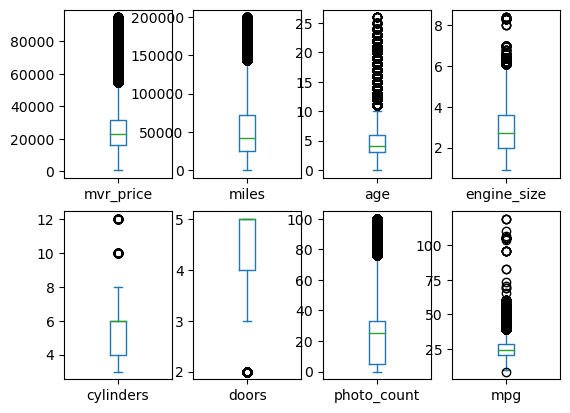

In [51]:
# boxplots of numeric variables
df[["mvr_price","miles","age","engine_size","cylinders","doors","photo_count","mpg"]].plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False)

In [52]:
# correlations of numeric variables with mvr_price
df.select_dtypes(include=['number']).corrwith(df["mvr_price"]).sort_values(ascending=False)

mvr_price         1.000000
year              0.582355
cylinders         0.431514
engine_size       0.417797
is_certified      0.117568
photo_count       0.110828
list_sale_diff    0.049902
doors             0.016757
latitude         -0.104460
longitude        -0.110853
annual_mileage   -0.269284
mpg              -0.364068
miles            -0.472897
age              -0.479131
dtype: float64

In [63]:
df.head()

,vin,status_date,miles,year,make,model,trim,vehicle_type,body_type,drivetrain,...,longitude,dealer_type,photo_count,mvr_purchase_date,mvr_price,age,mvr_purchase_month,annual_mileage,list_sale_diff,mpg
33,1C6RR7LG9FS713496,2017-10-01 01:29:36,14328.0,2015.0,RAM,Ram 1500 Pickup,SLT,Truck,Pickup Crew,4WD,...,-83.360001,Unknown,17,2017-09-30,31175.0,3.0,9.0,3582.0,-2.0,22.6
39,5J6RM3H34EL035166,2017-10-01 02:01:36,41853.0,2014.0,Honda,CR-V,LX,Truck,SUV,FWD,...,-84.540001,Unknown,17,2017-10-11,15050.0,4.0,10.0,8370.6,9.0,26.6
71,1HGCP3F84AA020112,2017-10-01 12:41:36,34119.0,2010.0,Honda,Accord,EX-L V6,Car,Sedan,FWD,...,-84.190002,Unknown,15,2017-10-09,12738.0,8.0,10.0,3791.0,7.0,23.5
72,5NPDH4AE1EH476957,2017-10-01 12:45:52,39594.0,2014.0,Hyundai,Elantra,SE,Car,Sedan,FWD,...,-84.260002,Unknown,16,2017-12-14,11503.0,4.0,12.0,7918.8,73.0,32.5
76,1N6AD0EV9EN770427,2017-10-01 13:28:32,45838.0,2014.0,Nissan,Frontier,PRO-4X,Truck,Pickup Crew,4WD,...,-82.930000,Unknown,0,2017-10-01,26250.0,4.0,10.0,9167.6,-1.0,17.7


## Model
**Consider target encoding**
- Can target encode each make/model/trim. If don't know combo, don't price it

In [ ]:
print(df.shape)

print(df.dropna().shape)

df.dropna(inplace=True)

hvf_cols = list(hvf_options.columns)

In [107]:
# selected columns
target_col = "mvr_price"
cat_cols = ["make", "vehicle_type", "body_type", "drivetrain", "fuel_type", "engine_block", "transmission", "base_exterior_color", "state", "dealer_type"]
num_cols = ["miles", "age", "engine_size", "cylinders", "doors", "photo_count", "mpg", "is_certified", "annual_mileage"]
hvf_cols = list(hvf_options.columns)

# all colls
all_cols = cat_cols + num_cols + hvf_cols + [target_col]

### Linear

In [123]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[num_cols + cat_cols],
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")


587953 train rows
146989 test rows


In [124]:
# scale numeric columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [125]:
# one-hot encode categorical columns
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

In [126]:
# combine numeric and categorical columns
X_train = np.concatenate([X_train[num_cols].values, X_train_cat], axis=1)
X_test = np.concatenate([X_test[num_cols].values, X_test_cat], axis=1)

In [127]:
# linear regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
test_results(y_test, y_pred_lr)

R2:  -100772323147.033
MAE:  18475822.08
MAPE:  496607.1 %
RMSE:  4088469775.21
Percent Underpayed:  46.0 %
Mean of Underpayment:  5774.34
Percent Overpayed:  54.0 %
Mean of Overpayment:  -34229426.11


### CatBoost

In [119]:
# test/train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df[all_cols].drop(target_col, axis=1),
    df[target_col],
    test_size=0.2,
    random_state=42,
)
print(f"{X_train.shape[0]} train rows")
print(f"{X_test.shape[0]} test rows")


587953 train rows
146989 test rows


In [120]:
from catboost import CatBoostRegressor

In [121]:
# fit

cb_model = CatBoostRegressor(
    cat_features=cat_cols,
    verbose=False
)

cb_model.fit(X_train, y_train, eval_set=(X_test, y_test))


In [122]:
# predict
y_pred_cb = cb_model.predict(X_test)

# results
test_results(y_test, y_pred_cb)

R2:  0.867
MAE:  3565.22
MAPE:  16.7 %
RMSE:  4704.93
Percent Underpayed:  46.7 %
Mean of Underpayment:  3820.58
Percent Overpayed:  53.3 %
Mean of Overpayment:  -3341.76


In [ ]:
import matplotlib.pyplot as plt

sorted_feature_importance = cb_model.feature_importances_.argsort()
myX = X_train.columns[sorted_feature_importance]
myY = cb_model.feature_importances_[sorted_feature_importance]
myX = myX[-20:]
myY = myY[-20:]
plt.barh(myX, myY)
plt.title("Variable Importance")
plt.show()